# 多臂老虎机问题

以下为引入所需库

In [3]:
import numpy as np
import matplotlib.pyplot as plt

## 问题模型
伯努利多臂老虎机模型

In [4]:
class BernoulliBandit:
    """伯努利多臂老虎机"""
    def __init__(self, k):
        # K对应老虎机的数量
        self.probs = np.random.uniform(size=k)  # 随机生成K个概率
        self.best_idx = np.argmax(self.probs)   # 获取概率最大的老虎机的索引
        self.best_prob = self.probs[self.best_idx]  # 获取最大概率
        self.K = k

    def step(self, k):
        # 拉动第k个臂，返回1或0（随机判断是否获奖）
        if np.random.rand() < self.probs[k]:
            return 1
        else:
            return 0

## 算法基本框架


In [5]:
class Solver:
    """ 多臂老虎机算法基本框架 """
    def __init__(self, bandit):
        self.bandit = bandit
        self.counts = np.zeros(self.bandit.K)  # 每个臂被拉动的次数
        self.regret = 0.
        self.actions = []
        self.regrets = []

    def update_regret(self, k):
        # 计算累积懊悔并保存
        self.regret += self.bandit.best_prob - self.bandit.probs[k]
        self.regrets.append(self.regret)

    def run_one_step(self):
        raise NotImplementedError   # 抽象方法，子类继承方法后若不重写则会报错

    def run(self, num_steps):
        for _ in range(num_steps):
            k = self.run_one_step()
            self.counts[k] += 1
            self.actions.append(k)
            self.update_regret(k)

## 探索和利用的平衡
**探索**(exploration)是尝试拉动更多可能的拉杆，这跟拉杆不一定会获得最大的奖励，但这种方案能够摸清楚所有拉杆的获奖情况。**利用**(exploitation)是指拉动已知期望奖励最大的那根拉杆，由于已知的信息仅仅来自有限次的交互观测，所以当前的最优拉杆不一定是全局最优的。

## $\epsilon$-贪心算法
$\epsilon$-贪婪算法在完全贪婪的基础上添加了噪声，每次以$1-\epsilon$选择以往经验中期望奖励估值最大的那根拉杆（利用），以概率$\epsilon$选择一根拉杆（探索），公示如下：

In [6]:
class EpsilonGreedy(Solver):
    """ ε-Greedy算法 """
    def __init__(self, bandit, epsilon=0.01, init_prob=1.0):
        super(EpsilonGreedy, self).__init__(bandit)
        self.epsilon = epsilon
        self.estimates = np.array([init_prob] * self.bandit.K)

    def run_one_step(self):
        if np.random.random() < self.epsilon:
            k = np.random.randint(0, self.bandit.K)     # 随机选择一个臂
        else:
            k = np.argmax(self.estimates)  # 选择当前平均收益最大的臂
        r = self.bandit.step(k)
        self.estimates[k] += 1.0 / (self.counts[k] + 1) * (r - self.estimates[k])
        return k

In [7]:
def plot_results(solvers, solver_names):
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets))
        plt.plot(time_list, solver.regrets, label=solver_names[idx])
    plt.xlabel("Time")
    plt.ylabel("Cumulative Regret")
    plt.title('%d-armed bandit' % solvers[0].bandit.K)
    plt.legend()
    plt.show()

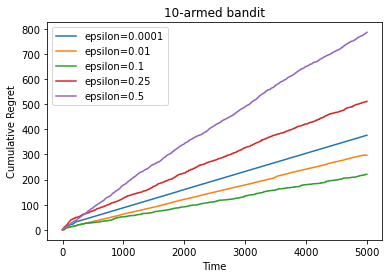

In [8]:
np.random.seed(0)
epsilons = [1e-4, 0.01, 0.1, 0.25, 0.5]
epsilon_greedy_solver_list = [
        EpsilonGreedy(BernoulliBandit(10), epsilon=eps) for eps in epsilons]
epsilon_greedy_solver_names = ["epsilon={}".format(eps) for eps in epsilons]
for solver in epsilon_greedy_solver_list:
    solver.run(5000)
plot_results(epsilon_greedy_solver_list, epsilon_greedy_solver_names)

## 衰减$\epsilon$-贪婪算法


In [9]:
class DecayingEpsilonGreedy(Solver):
    """" epsilon值随时间衰减的epsilon-贪婪算法,继承Solver类 """
    def __init__(self, bandit, init_prob=1.0):
        super(DecayingEpsilonGreedy, self).__init__(bandit)
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.total_count = 0

    def run_one_step(self):
        self.total_count += 1
        if np.random.random() < 1 / self.total_count:  # epsilon值随时间衰减
            k = np.random.randint(0, self.bandit.K)
        else:
            k = np.argmax(self.estimates)

        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])

        return k

epsilon值衰减的贪婪算法的累积懊悔为： 10.82338899350856


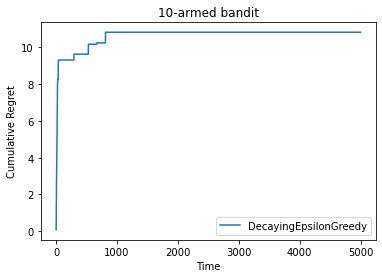

In [10]:
np.random.seed(0)
bandit_10_arm = BernoulliBandit(10)
decaying_epsilon_greedy_solver = DecayingEpsilonGreedy(bandit_10_arm)
decaying_epsilon_greedy_solver.run(5000)
print('epsilon值衰减的贪婪算法的累积懊悔为：', decaying_epsilon_greedy_solver.regret)
plot_results([decaying_epsilon_greedy_solver],["DecayingEpsilonGreedy"])

## 上置信界算法
### 算法原理
上置信界(upper confidence bound, UCB) 算法是一种经典的基于不确定性的策略方法，它的思想用到了非常著名的数学原理：**霍夫丁不等式** (Hoeffding's inequality)。在霍夫丁不等式中，令$X_1,\ldots,X_n$为$n$个独立同分布的随机变量，取值范围为$[0,1]$，其经验期望为$\bar{x}_{n}=\frac{1}{n}\sum_{j=1}^{n}X_{j}$，则有 
$$\mathbb{P}\left\{\mathbb{E}\left[X\right]\geq\bar{x}_n+u\right\}\leq e^{-2nu^2}$$
现在我们将霍夫丁不等式运用于多臂老虎机问题中。将$\hat Q_t(a)$带入$\bar x_t$，不等式中参数$u=\hat U_t(a)$代表不确定性度量。给定一个概率$p=e^{-2N_t(a)U_t(a)^2}$，根据霍夫丁不等式，我们有
$$Q_t(a)<\hat{Q}_t(a)+\hat{U}_t(a)$$
至少以$1-p$成立。当$p$很小时，上式就医很大概率成立，即$\hat{Q}_t(a)+\hat{U}_t(a)$是$Q_t(a)$(期望奖励)的一个上界。  此时，上置信界算法便选取期望奖励上界最大的动作，即$$a=\operatorname{argmax}_{a\in\mathcal{A}}\left[\hat{Q}(a)+\hat{U}(a)\right]$$
其中，$\hat U_t(a)$根据等式解得：$$\hat{U}_t(a)=\sqrt{\frac{-\log p}{2N_t(a)}}$$
因此，设定一个概率$p$后即可计算相应的不确定性度量$\hat U_t(a)$。 \
直观解释，UCB算法在每次选择拉杆前，先估计每根拉杆的期望奖励的上界，使得拉动每根拉杆的期望奖励只有一个较小的概率$p$超过这个上界，接着选出期望奖励上界的拉杆，从而选择最有可能获得最大期望奖励的拉杆。

### 算法编写
在具体实现过程中，设置$p=\frac{1}{t}$，并且在坟墓中为拉动每根拉杆的次数加上常熟1，以避免出现分母为0的情况，即此时$$\hat{U}_t(a)=\sqrt{\frac{\log t}{2(N_t(a)+1)}}$$
同时，设定一个系数$c$来控制不确定性的比重，此时$$a=\arg\max_{a\in\mathcal{A}}\hat{Q}(a)+c\cdot\hat{U}(a)$$


In [11]:
class UCB(Solver):
    def __init__(self, bandit, coef, init_prob=1.0):
        super(UCB, self).__init__(bandit)
        self.total_count = 0
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.coef = coef
        
    def run_one_step(self):
        self.total_count += 1
        ucb = self.estimates + self.coef * np.sqrt(np.log(self.total_count) / ( 2 * (self.counts + 1)))
        k = np.argmax(ucb)
        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])
        return k

上置信界算法的累积懊悔为： 80.85283670372556


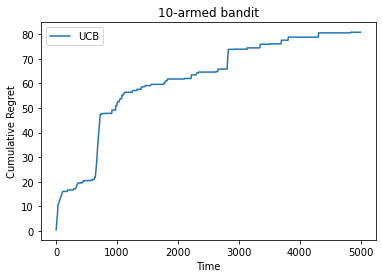

In [12]:
np.random.seed(0)
coef = 1  # 控制不确定性比重的系数
UCB_solver = UCB(bandit_10_arm, coef)
UCB_solver.run(5000)
print('上置信界算法的累积懊悔为：', UCB_solver.regret)
plot_results([UCB_solver], ["UCB"])

## 汤普森采样算法
### 基本思路
汤普森采样(Thompson sampling)，先假设拉动每根拉杆的奖励服从一个特定的概率分布，然后根据拉动每根拉杆的期望奖励来选择。但是由于己算所有拉杆的期望奖励的代加比较高，汤普森采样使用**采样**的方式，即根据当前每个动作$a$的奖励概率分布进行一轮采样，得到一组根据拉杆的奖励样本，再选择样本中奖励最大的动作。 \
可以看出，汤普森采样是一种计算所有拉杆的最高奖励概率的蒙特卡洛采样方法。
### 算法实现
了解了汤普森采样算法的基本思路后，我们需要解决另一个问题：怎样得到当前每个动作$a$的奖励概率分布并且在过程中进行更新？\
在实现过程中，通常使用**Beta分布**对当前每个动作的奖励概率分布进行建模。具体来说，若某拉杆被选择了$k$次，其中$m_1$次奖励为1，$m_2$次奖励为0，则该拉杆的奖励服从参数为$(m_1+1,m_2+1)$的Beta分布。 \


In [13]:
class ThompsonSampling(Solver):
    def __init__(self, bandit, init_a=1, init_b=1):
        super(ThompsonSampling, self).__init__(bandit)
        self._a = np.array([init_a] * self.bandit.K)
        self._b = np.array([init_b] * self.bandit.K)
        
    def run_one_step(self):
        samples = np.random.beta(self._a, self._b)
        k = np.argmax(samples)
        r = self.bandit.step(k)
        self._a[k] += r
        self._b[k] += 1 - r
        return k

汤普森采样算法的累积懊悔为： 25.543567041570626


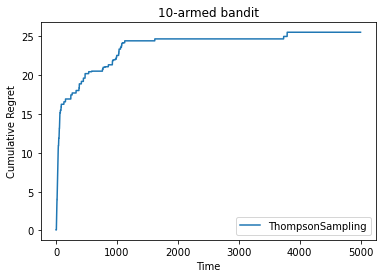

In [14]:
np.random.seed(1)
thompson_sampling_solver = ThompsonSampling(bandit_10_arm)
thompson_sampling_solver.run(5000)
print('汤普森采样算法的累积懊悔为：', thompson_sampling_solver.regret)
plot_results([thompson_sampling_solver], ["ThompsonSampling"])

## 总结
### 算法比较
通过实验我们可以得出以下结论：$\epsilon$-贪婪算法的累积懊悔是随时间线性增长的，而另外的三种算法的累积懊悔都是随时间次线性增长的（具体为对数形式增长）。
### MAB与RL
多臂老虎机问题与强化学习的一大区别在于其与环境的交互并不会改变环境，即多臂老虎机的每次交互的结果和以往的动作无关，所以可看作**无状态的强化学习** (Stateless Reinforcement Learning)。